# Lab 3 — dimensionality reduction
**Internet Analytics - Lab 3**

---

**Group:** *K*

**Names:**

* *Robin Lang*
* *Kim Lan Phan Hoang*

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la

import pickle

%matplotlib inline
plt.style.use("ggplot")

relevance_file_name = "relevance_array.npy"

## Exercice 3.1

## Construct the data matrix
Using PySpark on the cluster, create the array containing all the ratings from `genome-scores.txt`

In [2]:
movies = sc.textFile("/ix/ml-20m/movies.txt").map(json.loads)
tags = sc.textFile("/ix/ml-20m/genome-tags.txt").map(json.loads)
data = sc.textFile("/ix/ml-20m/genome-scores.txt").map(json.loads)

In [ ]:
n_movies = movies.map(lambda x: x["movieId"]).max()
n_tags = tags.map(lambda x: x["tagId"]).max()

In [ ]:
print("movies:", n_movies, "| tags:", n_tags)

In [ ]:
relevance_array = np.zeros((n_tags, n_movies), dtype=float)

for i in data.toLocalIterator():
    # we substract 1 from each index, to avoid the forst row / colon being empty,
    # as the ids start at 1
    relevance_array[i["tagId"]-1][i["movieId"]-1] = i["relevance"]

The following code allows us to save the previously done computations, so that we don't need to relaunch the expensive computation of the matrix, nor need the cluster, freeing up ressources for others.

Save the computed array to a file on disk

In [ ]:
np.save(relevance_file_name, relevance_array)

Load the array from disk, initializing the necessary constants

In [3]:
relevance_array = np.load(relevance_file_name)

n_movies = len(relevance_array[1])
n_tags = len(relevance_array)

### Plot the variance of each dimension / tag.

In [4]:
# compute the variance of each tag and save it into an array
rel_var = []
for i in relevance_array:
    rel_var.append(np.var(i))

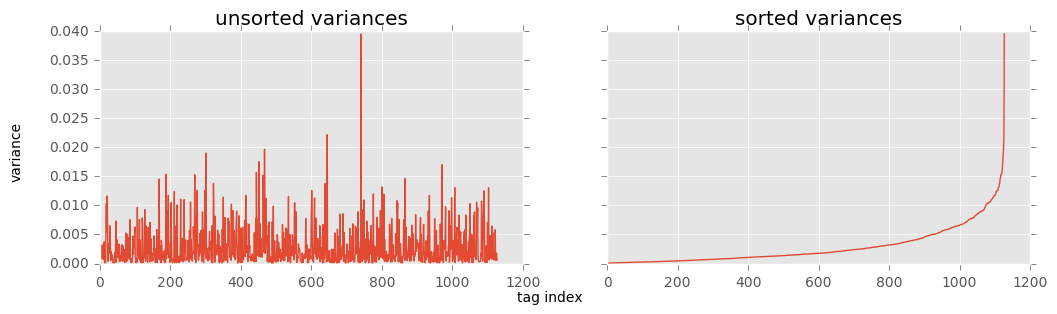

In [5]:
# plot the variances
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 3), sharey=True)
fig.text(0.5, 0.0, 'tag index', ha='center')
fig.text(0.05, 0.5, 'variance', va='center', rotation='vertical')

ax1.plot(rel_var)
ax1.set_title("unsorted variances")

ax2.plot(sorted(rel_var))
ax2.set_title("sorted variances")
plt.show()


### Plot the eigenvalues of the covariance matrix.

In [6]:
# compute covariance matrix
rel_cov = np.cov(relevance_array)
# the formula is:
#   rel_cov = 1/n_tags * relevance_array.T @ relevance_array
# which gives the same result as the above formula, but is way slower

# compute the eigenvalues and -vectors
rel_eigvals, rel_eigvecs = la.eigh(rel_cov)

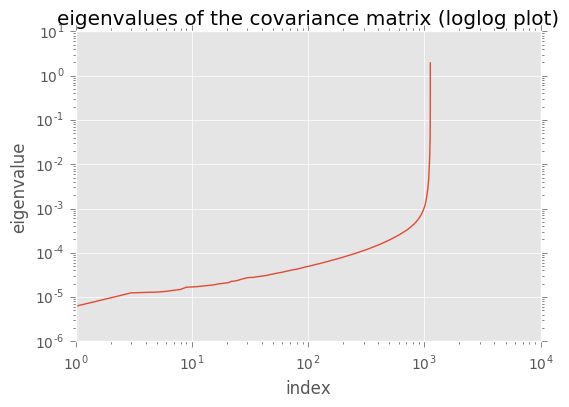

In [7]:
# plot the eigenvalues
plt.loglog(rel_eigvals)
plt.title("eigenvalues of the covariance matrix (loglog plot)")
plt.xlabel("index")
plt.ylabel("eigenvalue")
plt.show()

### Explain the implications for dimensionality reduction.

Most eigenvalues are very small (between $10^{-5}$ and $10^{-3}$), with very few large values. <br>
Since the dimensionality of the data is carried by the eigenvalues, this means that few eigenvalues are required to keep a significant portion of the variability. For example:

**How many principal directions do you need to capture $2 \over 3$ of the variability in the data?**

In [8]:
# compute the sum of all eigenvalues.
# 2/3 of the variability will be carried by eigenvalues that cover 2/3 of that sum
sum_eig = sum(rel_eigvals)
s = 0
n_eigvals = len(rel_eigvals)
count = 0

while s < sum_eig*2/3:
    # the eigenvalues are sorted from smallest to largest,
    # so to get the n-th largest, all that is needed is to get the
    # n-th last element from the array
    s += rel_eigvals[n_eigvals-count-1]
    count += 1

print("to capture 2/3 of the variability you need", count, "principal directions")

to capture 2/3 of the variability you need 3 principal directions


## Exercice 3.2

### For the five first principal directions, find the 10 tags that have the highest and lowest coordinates in that direction.

In [9]:
# first 5 principle directions
rel_dirs = []
for i in range(5):
    rel_dirs.append(rel_cov @ rel_eigvecs[-i-1])

In [10]:
# retrieve the name of a tag by index
def getTagName(i):
    return tags.filter(lambda x: x["tagId"] == i+1).take(1)[0]["tag"]

# print the names from a list of tag indeces
def printTags(l, dir):
    for i in l:
        print("   ", dir[i], ":", getTagName(i))

In [11]:
def find_tags(direction):
    # find indeces of 10 highest / lowest entries
    top10 = np.argsort(-direction)[:10]
    bottom10 = np.argsort(direction)[:10]

    print("  top10 (largest to smallest):")
    printTags(top10, direction)
    print("  bottom10 (smallest to largest):")
    printTags(bottom10, direction)

In [12]:
count = ["1st", "2nd", "3rd", "4th", "5th"]

for i in range(5):
    print(count[i], "principal direction:")
    find_tags(rel_dirs[i])
    print("")

1st principal direction:
  top10 (largest to smallest):
    0.00408974341015 : original
    0.00306611406518 : great ending
    0.00293642113118 : mentor
    0.00292593174661 : dialogue
    0.00277424141257 : great
    0.00276465655914 : story
    0.00273015860636 : storytelling
    0.00268612542398 : good
    0.0026220352338 : good soundtrack
    0.00255990893073 : catastrophe
  bottom10 (smallest to largest):
    1.93366137854e-05 : hannibal lecter
    3.01643721523e-05 : iraq war
    3.52018897445e-05 : swedish
    3.87716669739e-05 : batman
    4.1120358451e-05 : vietnam war
    4.30617257492e-05 : beatles
    4.99244950592e-05 : 9/11
    5.02116196097e-05 : iran
    5.33817393121e-05 : neo-nazis
    5.38058466111e-05 : aardman

2nd principal direction:
  top10 (largest to smallest):
    0.00119078919816 : predictable
    0.000996382298644 : action
    0.000988587903866 : so bad it's funny
    0.000890407629481 : bad plot
    0.000818849036364 : good action
    0.000804662743984 : 

### What concepts would you use to describe these dimensions?

The first direction has high values for tags including story, original, whereas most tags in the bottom 10 are about war. So this tag is about good, story-centered movies with happy endings.

The second direction seems to mostly be centered around either action movies, or movies that would fall into the category "so bad it's good".

The third direction is quite similar to the first direction, but with that addition of tags such as "brutality", and the absence of war from the bottom tags. So this is once again about good and story-centered, but this time more violent (or adult) movies.

The fourth direction is rather bizarre, as the top contains both "original" and "adaptation". Nevertheless, the tags once again are close to the ones of the first direction, with the addition of "family" or "mentor" at the top, and many stereotypically girlie tags ("college", "teenager", "cheerleading" - then again, guys might be even more into that last one), it might be a category of more "serious" movies, for an older audience, that might not mind some violence (as that is entirely absent from the bottom), but want to avoid cheesy teenager topics.

The fifth direction in some regards seems to be nearly the opposite of the first direction. While I could discuss the difference betwween the tags in the top and the bottom, i feel the fact that every single value in this principle direction is negative (since the biggest value is negative, so must all others). This might be a category of overall unpopular, or disliked movies.

## Create a dict which maps every tag to it's coordinates in the first 5 principal directions

In [13]:
# construct the dict
tag_dict = {}
for i in tags.toLocalIterator():
    tmp = []
    for j in range(5):
        tmp.append(rel_dirs[j][i["tagId"]-1])
    tag_dict[i["tag"]] = tmp

In [14]:
# save dict to file
with open('tag_dict.txt', 'wb') as file:
    pickle.dump(tag_dict, file)

In [15]:
# open dict stored on disk
with open("tag_dict.txt", "rb") as file:
    tag_dict_load = pickle.load(file)

## Exercice 3.3

### Create an interactive plot that displays the 2D-projection of the movies using bokeh and its hover tool. Color the nodes by their Rotten Tomatoes score.

In [16]:
from bokeh.io import show, output_notebook
from bokeh.plotting import figure, ColumnDataSource
from bokeh.models import HoverTool, ResetTool, PanTool, WheelZoomTool, SaveTool
output_notebook()

Loading BokehJS ...

In [17]:
# Reading an object from disk.
with open("selected-movies.pickle", "rb") as f:
    movies = pickle.load(f, encoding="utf-8")
    
for movie in movies:
#    print(movie)
    pass

In [18]:
projected_x = [] # first principal direction
projected_y = [] # second principal direction

for i in movies:
    projected_x.append(np.dot(relevance_array.T[i[0]-1], rel_dirs[0]))
    projected_y.append(np.dot(relevance_array.T[i[0]-1], rel_dirs[1]))

In [19]:
# Continuous colors
from matplotlib.colors import rgb2hex 

# colors:   0% -> red
#          50% -> yellow
#         100% -> green
# interpolated in between
def rottenColor(val):
    if val<0.5:
        return rgb2hex([1.0, 2*val, 0.0])
    else:
        return rgb2hex([2*(1.0-val), 1.0, 0.0])

source = ColumnDataSource(
    data={
        "x": projected_x,
        "y": projected_y,
        "name": [x[1] for x in movies],
        "color": [rottenColor(x[2]) for x in movies],
    })

hover = HoverTool(
    tooltips=[
        ("Name", "@name"),
    ])
tools = [hover, ResetTool(), PanTool(), WheelZoomTool(), SaveTool()]

p = figure(plot_width=960, plot_height=960, tools=tools, title="movies and their ratings")
p.circle("x", "y", source=source, size=20, color="color", alpha=1.0)
show(p)

### Explain the coordinates of a few of the movies.

The first principal direction is on the X direction, the second is on Y. A result close to 0 means that movie is perfectly represented by that principal direction. For example, "King's Speech" (lower right) is very close to 0 on the Y axis, which means that its tags are almost perfectly represented by that direction.

"Spiderman" (top middle) however has a comparatively large value on both axis, which shows that this movie is not too well represented by the tags in either of those two principal directions.

### How do the PCA directions correlate with the Rotten Tomatoes score?

Overall the ratings are overwhelmingly positive, with almost all ratings that approach the yellow or red being near the top left of this graph. It seems that from top left, to bottom right, the ratings overall increase.

This might show that lower rated movies match better with the forst principle direction, whereas better rated movies have tags closer to the ones of the second principal direction.